In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 4060 Laptop GPU


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Parameters
IMG_SIZE = 48
BATCH_SIZE = 128
EPOCHS = 100
PATIENCE = 5
DATASET_DIR = 'D:/RuhunaNew/Academic/Research/Facial_Recog_Repo/Group_50_Repo/Datasets/Dataset_48_48_5000_per_each'
NUM_CLASSES = 9

# Dataset class
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        self.class_map = {name: idx for idx, name in enumerate(sorted(os.listdir(root_dir)))}
        for emotion in self.class_map:
            folder = os.path.join(root_dir, emotion)
            for fname in os.listdir(folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    self.samples.append(os.path.join(folder, fname))
                    self.labels.append(self.class_map[emotion])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = cv2.imread(self.samples[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.expand_dims(img, axis=0)
        img = torch.tensor(img, dtype=torch.float32) / 255.0
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Transforms
transform = transforms.Normalize([0.5], [0.5])

# Dataset preparation
full_dataset = EmotionDataset(DATASET_DIR, transform=transform)
train_idx, val_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.2, stratify=full_dataset.labels, random_state=42)
train_set = torch.utils.data.Subset(full_dataset, train_idx)
val_set = torch.utils.data.Subset(full_dataset, val_idx)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Using device: cuda


Epoch 1/100: 100%|██████████| 282/282 [07:15<00:00,  1.55s/batch, loss=1.43]


Epoch 1/100 - Loss: 1.9374 - Val Acc: 0.4223


Epoch 2/100: 100%|██████████| 282/282 [00:33<00:00,  8.38batch/s, loss=1.84]


Epoch 2/100 - Loss: 1.5886 - Val Acc: 0.4560


Epoch 3/100: 100%|██████████| 282/282 [00:35<00:00,  7.98batch/s, loss=1.48]


Epoch 3/100 - Loss: 1.4916 - Val Acc: 0.4906


Epoch 4/100: 100%|██████████| 282/282 [00:35<00:00,  7.91batch/s, loss=1.54]


Epoch 4/100 - Loss: 1.4215 - Val Acc: 0.5238


Epoch 5/100: 100%|██████████| 282/282 [00:34<00:00,  8.17batch/s, loss=1.51]


Epoch 5/100 - Loss: 1.3529 - Val Acc: 0.5309


Epoch 6/100: 100%|██████████| 282/282 [00:34<00:00,  8.17batch/s, loss=1.43]


Epoch 6/100 - Loss: 1.2951 - Val Acc: 0.5544


Epoch 7/100: 100%|██████████| 282/282 [00:34<00:00,  8.08batch/s, loss=1.08]


Epoch 7/100 - Loss: 1.2497 - Val Acc: 0.5708


Epoch 8/100: 100%|██████████| 282/282 [00:34<00:00,  8.12batch/s, loss=1.27]


Epoch 8/100 - Loss: 1.2004 - Val Acc: 0.5752


Epoch 9/100: 100%|██████████| 282/282 [00:34<00:00,  8.18batch/s, loss=1.28] 


Epoch 9/100 - Loss: 1.1501 - Val Acc: 0.5816


Epoch 10/100: 100%|██████████| 282/282 [00:34<00:00,  8.20batch/s, loss=1.21] 


Epoch 10/100 - Loss: 1.1121 - Val Acc: 0.5832


Epoch 11/100: 100%|██████████| 282/282 [00:34<00:00,  8.24batch/s, loss=1.17] 


Epoch 11/100 - Loss: 1.0798 - Val Acc: 0.5939


Epoch 12/100: 100%|██████████| 282/282 [00:34<00:00,  8.21batch/s, loss=0.716]


Epoch 12/100 - Loss: 1.0364 - Val Acc: 0.5987


Epoch 13/100: 100%|██████████| 282/282 [00:34<00:00,  8.18batch/s, loss=1.03] 


Epoch 13/100 - Loss: 0.9930 - Val Acc: 0.6029


Epoch 14/100: 100%|██████████| 282/282 [00:34<00:00,  8.18batch/s, loss=0.827]


Epoch 14/100 - Loss: 0.9678 - Val Acc: 0.6017


Epoch 15/100: 100%|██████████| 282/282 [00:34<00:00,  8.17batch/s, loss=0.987]


Epoch 15/100 - Loss: 0.9410 - Val Acc: 0.6092


Epoch 16/100: 100%|██████████| 282/282 [00:34<00:00,  8.14batch/s, loss=0.961]


Epoch 16/100 - Loss: 0.9064 - Val Acc: 0.6076


Epoch 17/100: 100%|██████████| 282/282 [00:34<00:00,  8.12batch/s, loss=1.1]  


Epoch 17/100 - Loss: 0.8835 - Val Acc: 0.6056


Epoch 18/100: 100%|██████████| 282/282 [00:34<00:00,  8.20batch/s, loss=0.585]


Epoch 18/100 - Loss: 0.8548 - Val Acc: 0.6173


Epoch 19/100: 100%|██████████| 282/282 [00:30<00:00,  9.32batch/s, loss=0.836]


Epoch 19/100 - Loss: 0.8328 - Val Acc: 0.6099


Epoch 20/100: 100%|██████████| 282/282 [00:33<00:00,  8.30batch/s, loss=0.788]


Epoch 20/100 - Loss: 0.8075 - Val Acc: 0.6121


Epoch 21/100: 100%|██████████| 282/282 [00:34<00:00,  8.17batch/s, loss=1.18] 


Epoch 21/100 - Loss: 0.7943 - Val Acc: 0.6199


Epoch 22/100: 100%|██████████| 282/282 [00:34<00:00,  8.19batch/s, loss=0.872]


Epoch 22/100 - Loss: 0.7819 - Val Acc: 0.6130


Epoch 23/100: 100%|██████████| 282/282 [00:34<00:00,  8.16batch/s, loss=0.789]


Epoch 23/100 - Loss: 0.7653 - Val Acc: 0.6202


Epoch 24/100: 100%|██████████| 282/282 [00:34<00:00,  8.19batch/s, loss=0.624]


Epoch 24/100 - Loss: 0.7406 - Val Acc: 0.6242


Epoch 25/100: 100%|██████████| 282/282 [00:34<00:00,  8.12batch/s, loss=0.538]


Epoch 25/100 - Loss: 0.7213 - Val Acc: 0.6236


Epoch 26/100: 100%|██████████| 282/282 [00:34<00:00,  8.15batch/s, loss=1.09] 


Epoch 26/100 - Loss: 0.7010 - Val Acc: 0.6213


Epoch 27/100: 100%|██████████| 282/282 [00:34<00:00,  8.22batch/s, loss=0.667]


Epoch 27/100 - Loss: 0.6946 - Val Acc: 0.6291


Epoch 28/100: 100%|██████████| 282/282 [00:35<00:00,  8.02batch/s, loss=0.703]


Epoch 28/100 - Loss: 0.6888 - Val Acc: 0.6223


Epoch 29/100: 100%|██████████| 282/282 [00:34<00:00,  8.10batch/s, loss=0.741]


Epoch 29/100 - Loss: 0.6747 - Val Acc: 0.6273


Epoch 30/100: 100%|██████████| 282/282 [00:34<00:00,  8.13batch/s, loss=0.581]


Epoch 30/100 - Loss: 0.6639 - Val Acc: 0.6282


Epoch 31/100: 100%|██████████| 282/282 [00:34<00:00,  8.14batch/s, loss=0.67] 


Epoch 31/100 - Loss: 0.6477 - Val Acc: 0.6222


Epoch 32/100: 100%|██████████| 282/282 [00:34<00:00,  8.15batch/s, loss=0.483]


Epoch 32/100 - Loss: 0.6443 - Val Acc: 0.6273

Early stopping at epoch 32


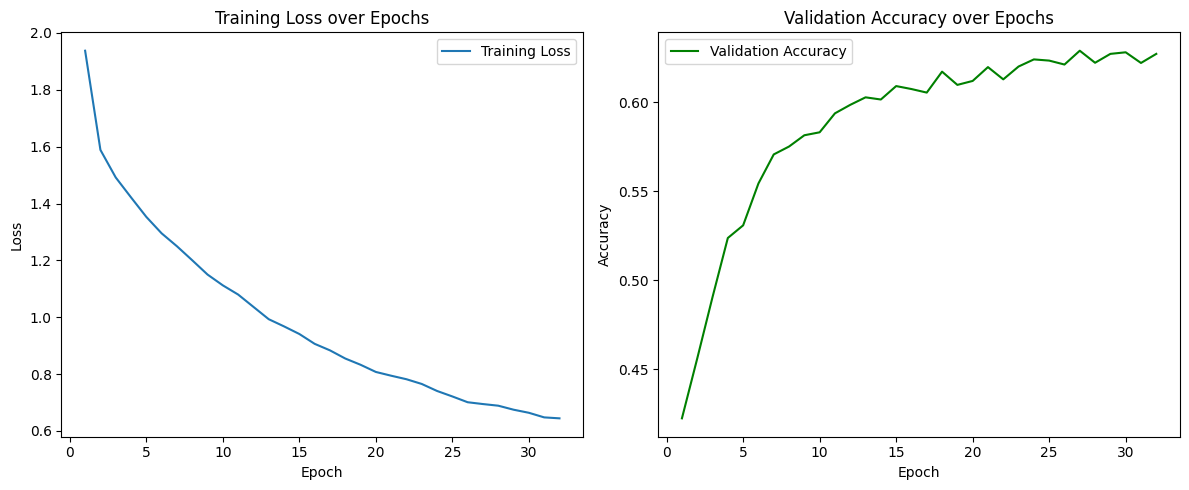

In [ ]:
# Optimized CNN Model
import torch
import torch.nn as nn

class LightweightEmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(LightweightEmotionCNN, self).__init__()
        
        # First depthwise separable block
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 1, 3, padding=1, groups=1),  # Depthwise
            nn.ReLU(),
            nn.Conv2d(1, 32, 1),  # Pointwise
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # Second depthwise separable block
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1, groups=32),  # Depthwise
            nn.ReLU(),
            nn.Conv2d(32, 64, 1),  # Pointwise
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )
        
        # Third depthwise separable block
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, groups=64),  # Depthwise
            nn.ReLU(),
            nn.Conv2d(64, 128, 1),  # Pointwise
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )
        
        # Classification head with global average pooling
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x
# Initialize model
model = LightweightEmotionCNN(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training with early stopping
train_losses = []
val_accuracies = []
best_val_acc = 0
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch") as tepoch:
        for imgs, labels in tepoch:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            tepoch.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Early Stopping Check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_state)

# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
# save the model
torch.save(model.state_dict(), 'emotion_model_48x48.pth')



In [4]:
# initial cnn model
import torch
import torch.nn as nn
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2), nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE//4) * (IMG_SIZE//4), 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [12]:
# get the saved model summary
%pip install torchsummary --quiet

from torchsummary import summary

summary(model, (1, IMG_SIZE, IMG_SIZE))

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,496
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
           Dropout-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]          73,856
             ReLU-10          [-1, 128, 24, 24]               0
      BatchNorm2d-11          [-1, 128, 24, 24]             256
        MaxPool2d-12          [-1, 128, 12, 12]               0
          Dropout-13          [-1, 12

In [2]:
import torch.nn as nn

class LightweightEmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(LightweightEmotionCNN, self).__init__()
        
        # First depthwise separable block
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 1, 3, padding=1, groups=1),  # Depthwise
            nn.ReLU(),
            nn.Conv2d(1, 32, 1),  # Pointwise
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # Second depthwise separable block
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1, groups=32),  # Depthwise
            nn.ReLU(),
            nn.Conv2d(32, 64, 1),  # Pointwise
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )
        
        # Third depthwise separable block
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, groups=64),  # Depthwise
            nn.ReLU(),
            nn.Conv2d(64, 128, 1),  # Pointwise
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )
        
        # Classification head with global average pooling
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Parameters
IMG_SIZE = 48
BATCH_SIZE = 512
EPOCHS = 150
PATIENCE = 5
DATASET_DIR = r'D:\RuhunaNew\Academic\Research\Facial_Recog_Repo\Group_50_Repo\Datasets\Dataset_1000_48_48'
NUM_CLASSES = 9

# Define transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, saturation
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL (for consistency)
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

# Dataset class
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        self.class_map = {name: idx for idx, name in enumerate(sorted(os.listdir(root_dir)))}
        for emotion in self.class_map:
            folder = os.path.join(root_dir, emotion)
            for fname in os.listdir(folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    self.samples.append(os.path.join(folder, fname))
                    self.labels.append(self.class_map[emotion])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = cv2.imread(self.samples[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = torch.tensor(img, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
        img = img.unsqueeze(0)  # Add channel dimension: [1, H, W]
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Dataset preparation
full_dataset = EmotionDataset(DATASET_DIR)  # Initialize without transform
train_idx, val_idx = train_test_split(
    np.arange(len(full_dataset)), 
    test_size=0.2, 
    stratify=full_dataset.labels, 
    random_state=42
)

# Create subsets with specific transforms
train_set = torch.utils.data.Subset(
    EmotionDataset(DATASET_DIR, transform=train_transform), 
    train_idx
)
val_set = torch.utils.data.Subset(
    EmotionDataset(DATASET_DIR, transform=val_transform), 
    val_idx
)

# Data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Using device: cuda


c:\Users\LOQ\anaconda3\envs\pythonenv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/100: 100%|██████████| 15/15 [01:35<00:00,  6.39s/batch, loss=2]   


Epoch 1/100 - Train Loss: 2.9286 - Val Loss: 3.1840 - Val Acc: 0.1750


Epoch 2/100: 100%|██████████| 15/15 [00:09<00:00,  1.65batch/s, loss=1.97]


Epoch 2/100 - Train Loss: 2.0075 - Val Loss: 2.0720 - Val Acc: 0.2767


Epoch 3/100: 100%|██████████| 15/15 [00:08<00:00,  1.68batch/s, loss=1.84]


Epoch 3/100 - Train Loss: 1.8714 - Val Loss: 1.9640 - Val Acc: 0.3111


Epoch 4/100: 100%|██████████| 15/15 [00:09<00:00,  1.65batch/s, loss=1.85]


Epoch 4/100 - Train Loss: 1.7744 - Val Loss: 1.7334 - Val Acc: 0.3539


Epoch 5/100: 100%|██████████| 15/15 [00:09<00:00,  1.66batch/s, loss=1.82]


Epoch 5/100 - Train Loss: 1.6969 - Val Loss: 1.6472 - Val Acc: 0.3922


Epoch 6/100: 100%|██████████| 15/15 [00:09<00:00,  1.66batch/s, loss=1.75]


Epoch 6/100 - Train Loss: 1.6481 - Val Loss: 1.5758 - Val Acc: 0.4089


Epoch 7/100: 100%|██████████| 15/15 [00:08<00:00,  1.67batch/s, loss=1.44]


Epoch 7/100 - Train Loss: 1.5942 - Val Loss: 1.5395 - Val Acc: 0.4267


Epoch 8/100: 100%|██████████| 15/15 [00:09<00:00,  1.66batch/s, loss=1.66]


Epoch 8/100 - Train Loss: 1.5404 - Val Loss: 1.5229 - Val Acc: 0.4278


Epoch 9/100: 100%|██████████| 15/15 [00:08<00:00,  1.69batch/s, loss=1.71]


Epoch 9/100 - Train Loss: 1.5073 - Val Loss: 1.4727 - Val Acc: 0.4450


Epoch 10/100: 100%|██████████| 15/15 [00:08<00:00,  1.69batch/s, loss=1.38]


Epoch 10/100 - Train Loss: 1.4616 - Val Loss: 1.4488 - Val Acc: 0.4561


Epoch 11/100: 100%|██████████| 15/15 [00:08<00:00,  1.68batch/s, loss=1.4] 


Epoch 11/100 - Train Loss: 1.4247 - Val Loss: 1.4485 - Val Acc: 0.4539


Epoch 12/100: 100%|██████████| 15/15 [00:08<00:00,  1.69batch/s, loss=1.55]


Epoch 12/100 - Train Loss: 1.4014 - Val Loss: 1.4325 - Val Acc: 0.4544


Epoch 13/100: 100%|██████████| 15/15 [00:09<00:00,  1.64batch/s, loss=1.37]


Epoch 13/100 - Train Loss: 1.3644 - Val Loss: 1.4038 - Val Acc: 0.4650


Epoch 14/100: 100%|██████████| 15/15 [00:08<00:00,  1.69batch/s, loss=0.885]


Epoch 14/100 - Train Loss: 1.3200 - Val Loss: 1.3826 - Val Acc: 0.4789


Epoch 15/100: 100%|██████████| 15/15 [00:08<00:00,  1.69batch/s, loss=0.987]


Epoch 15/100 - Train Loss: 1.2812 - Val Loss: 1.3931 - Val Acc: 0.4833


Epoch 16/100: 100%|██████████| 15/15 [00:08<00:00,  1.68batch/s, loss=1.25]


Epoch 16/100 - Train Loss: 1.2482 - Val Loss: 1.3796 - Val Acc: 0.4950


Epoch 17/100: 100%|██████████| 15/15 [00:08<00:00,  1.68batch/s, loss=1.57]


Epoch 17/100 - Train Loss: 1.2213 - Val Loss: 1.3851 - Val Acc: 0.4906


Epoch 18/100: 100%|██████████| 15/15 [00:09<00:00,  1.66batch/s, loss=1.19]


Epoch 18/100 - Train Loss: 1.1986 - Val Loss: 1.3497 - Val Acc: 0.4850


Epoch 19/100: 100%|██████████| 15/15 [00:08<00:00,  1.69batch/s, loss=1.15]


Epoch 19/100 - Train Loss: 1.1771 - Val Loss: 1.3789 - Val Acc: 0.4939


Epoch 20/100: 100%|██████████| 15/15 [00:08<00:00,  1.69batch/s, loss=1.48]


Epoch 20/100 - Train Loss: 1.1294 - Val Loss: 1.3844 - Val Acc: 0.4944


Epoch 21/100: 100%|██████████| 15/15 [00:08<00:00,  1.71batch/s, loss=1.19]


Epoch 21/100 - Train Loss: 1.1027 - Val Loss: 1.3670 - Val Acc: 0.4839


Epoch 22/100: 100%|██████████| 15/15 [00:09<00:00,  1.67batch/s, loss=1.05]


Epoch 22/100 - Train Loss: 1.0554 - Val Loss: 1.3755 - Val Acc: 0.5011


Epoch 23/100: 100%|██████████| 15/15 [00:09<00:00,  1.63batch/s, loss=0.89]


Epoch 23/100 - Train Loss: 1.0623 - Val Loss: 1.3419 - Val Acc: 0.5006


Epoch 24/100: 100%|██████████| 15/15 [00:09<00:00,  1.63batch/s, loss=1.17] 


Epoch 24/100 - Train Loss: 0.9973 - Val Loss: 1.3702 - Val Acc: 0.5083


Epoch 25/100: 100%|██████████| 15/15 [00:09<00:00,  1.61batch/s, loss=0.99] 


Epoch 25/100 - Train Loss: 0.9641 - Val Loss: 1.3601 - Val Acc: 0.5028


Epoch 26/100: 100%|██████████| 15/15 [00:08<00:00,  1.69batch/s, loss=0.698]


Epoch 26/100 - Train Loss: 0.9298 - Val Loss: 1.4022 - Val Acc: 0.4967


Epoch 27/100: 100%|██████████| 15/15 [00:08<00:00,  1.70batch/s, loss=1.15] 


Epoch 27/100 - Train Loss: 0.8718 - Val Loss: 1.3568 - Val Acc: 0.5217


Epoch 28/100: 100%|██████████| 15/15 [00:09<00:00,  1.66batch/s, loss=0.87] 


Epoch 28/100 - Train Loss: 0.8752 - Val Loss: 1.4455 - Val Acc: 0.5078


Epoch 29/100: 100%|██████████| 15/15 [00:08<00:00,  1.68batch/s, loss=1.04] 


Epoch 29/100 - Train Loss: 0.8504 - Val Loss: 1.3899 - Val Acc: 0.5100


Epoch 30/100: 100%|██████████| 15/15 [00:08<00:00,  1.67batch/s, loss=0.661]


Epoch 30/100 - Train Loss: 0.7994 - Val Loss: 1.3857 - Val Acc: 0.5178


Epoch 31/100: 100%|██████████| 15/15 [00:08<00:00,  1.69batch/s, loss=0.653]


Epoch 31/100 - Train Loss: 0.7405 - Val Loss: 1.3989 - Val Acc: 0.5144


Epoch 32/100: 100%|██████████| 15/15 [00:08<00:00,  1.69batch/s, loss=0.68] 


Epoch 32/100 - Train Loss: 0.7200 - Val Loss: 1.4044 - Val Acc: 0.5139


Epoch 33/100: 100%|██████████| 15/15 [00:08<00:00,  1.70batch/s, loss=0.675]


Epoch 33/100 - Train Loss: 0.7142 - Val Loss: 1.4148 - Val Acc: 0.5194


Epoch 34/100: 100%|██████████| 15/15 [00:08<00:00,  1.68batch/s, loss=0.727]


Epoch 34/100 - Train Loss: 0.7060 - Val Loss: 1.4208 - Val Acc: 0.5189


Epoch 35/100: 100%|██████████| 15/15 [00:08<00:00,  1.72batch/s, loss=0.715]


Epoch 35/100 - Train Loss: 0.6951 - Val Loss: 1.4236 - Val Acc: 0.5211


Epoch 36/100: 100%|██████████| 15/15 [00:08<00:00,  1.73batch/s, loss=0.577]


Epoch 36/100 - Train Loss: 0.6997 - Val Loss: 1.4240 - Val Acc: 0.5200


Epoch 37/100: 100%|██████████| 15/15 [00:08<00:00,  1.73batch/s, loss=0.656]


Epoch 37/100 - Train Loss: 0.6859 - Val Loss: 1.4254 - Val Acc: 0.5194

Early stopping at epoch 37


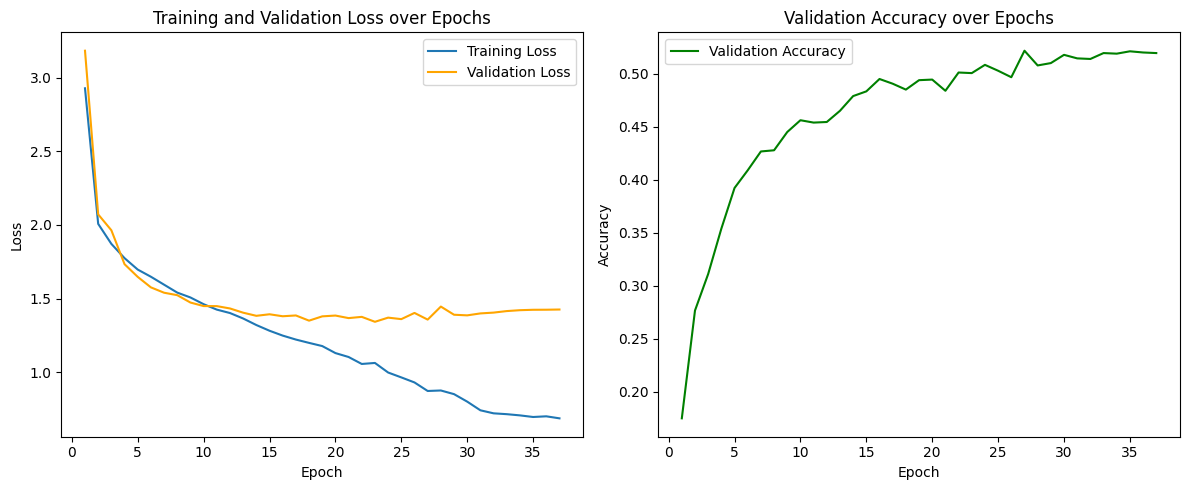

In [10]:
model = EmotionCNN(num_classes=9).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training with early stopping
EPOCHS = 100
PATIENCE = 10
train_losses = []
val_losses = []
val_accuracies = []
best_val_acc = 0
epochs_no_improve = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch") as tepoch:
        for imgs, labels in tepoch:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            tepoch.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Learning rate scheduler step
    scheduler.step(avg_val_loss)

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_state)

# Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# save the model
torch.save(model.state_dict(), 'emotion_model_48x48_5000_cnn.pth')